In [3]:
import turtlebot4_wrapper

turtlebot4_wrapper.use_hardware()
# turtlebot4_wrapper.use_simulation()

# load ROS library
import rclpy
if not rclpy.ok():
    rclpy.init()

# Instantiate Wrapper. The subscribes and publishes the relevant topics and connects the actions.
if not "robot" in globals():
    robot = turtlebot4_wrapper.Robot()

You are connected to uwbot-02
Robot is reachable


Could not determine the type for the passed topic


ros2 topic echo --once /ip failed. Proceed with caution.
ros2 topic subscription working. Everything is working as expected.


In [9]:
# Make sure we have fresh data by waiting for a new message
robot.reset_odometry()
robot.battery_state_future = rclpy.Future()
robot.spin_until_future_completed(robot.battery_state_future)

# Pretty print the contents of the message
print("Battery {0:2.3}%, charging with {1:2.2}A".format(
    robot.last_battery_state_msg.percentage*100,
    robot.last_battery_state_msg.current
))

Battery 37.0%, charging with -1.2A


In [28]:
robot.undock()

irobot_create_msgs.action.Undock_Result(is_docked=False)

# PLOT POINTS

/tmp/ipykernel_2135/990165653.py:26: RuntimeWarning: invalid value encountered in matmul
  transformed_points = [numpy.matmul(T,


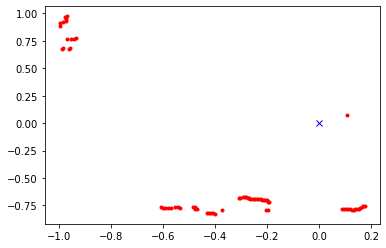

In [3]:
from matplotlib import pyplot as plt
import numpy  as np
# Plot robot position from odometry
# Use blue cross marker to designate the robot position
robot.battery_state_future = rclpy.Future()
robot.spin_until_future_completed(robot.battery_state_future)
pose = robot.last_odom_msg.pose.pose
plt.plot([pose.position.y],[pose.position.x],'bx') # TODO: show robot front

def get_distance(x1 , y1 , x2 , y2):
    return np.sqrt((np.square(x2-x1))+(np.square(y2-y1)))
# Plot lidar points from last message

def plot_lidar_scan_points(msg,pose):
    # Convert received lidar points into cartesian coordinates considering the current position from odometry
    import numpy
    points = [(numpy.cos(angle)*radius,numpy.sin(angle)*radius) for angle, radius \
              in zip(numpy.linspace(msg.angle_min,msg.angle_max,len(msg.ranges)),msg.ranges)]

    T = robot.reduce_transform_to_2D(robot.convert_odom_to_transform(pose))
    
    # remove points which cannot be measured
    # filtered_points = filter(lambda x: numpy.isfinite(x).all(),points)
    filtered_points = points
    # display points in world frame
    transformed_points = [numpy.matmul(T,
        numpy.vstack([ numpy.atleast_2d(x).T,numpy.ones((1,1)) ]) ) for x in 
                          filtered_points]
    transformed_points = [pnt for pnt in transformed_points if abs(pnt[0]) <= 1 and abs(pnt[1]) <= 1]           
    transformed_points = [pnt for pnt in transformed_points if abs(pnt[0]) >= 0 and abs(pnt[1]) >= 0.075]   

    for pt in transformed_points:
        pt[0] = -pt[0]
        pt[1] = -pt[1]

    return transformed_points

    # plt.plot(
    #     [x[0] for x in transformed_points],
    #     [x[1] for x in transformed_points],'r.')

transformed_points = plot_lidar_scan_points(robot.last_scan_msg,pose)


    # RADIUS METHOD if np.sqrt(pt[0]**2 + pt[1]**2) <= 3:  # Points within a distance of 3 units from (0, 0)
plt.plot(
        [x[0] for x in transformed_points],
        [x[1] for x in transformed_points],'r.')

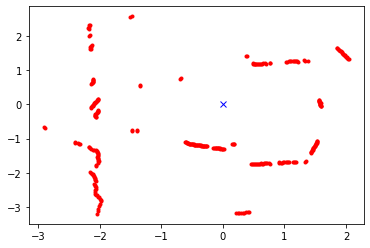

In [10]:
from matplotlib import pyplot as plt
import numpy as np
# Plot robot position from odometry
# Use blue cross marker to designate the robot position

robot.scan_future = rclpy.Future()
robot.odom_future = rclpy.Future()
robot.spin_until_future_completed(robot.scan_future);
robot.spin_until_future_completed(robot.odom_future);
pose = robot.last_odom_msg.pose.pose

T_base_lidar = np.array([[ 2.22044605e-16, -1.00000000e+00, -4.00000000e-02],
       [ 1.00000000e+00,  2.22044605e-16,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])


# print(robot.last_scan_msg)
# print(robot.last_odom_msg)
# print(robot.reduce_transform_to_2D(robot.get_tf_transform("base_link","rplidar_link")))
def get_distance(x1 , y1 , x2 ,y2):
    return np.sqrt((x2-x1)**2+(y2-y1)**2)

def is_not_rods(pt , x2 ,y2):
    if get_distance(pt[0] ,pt[1] , x2, y2) >= 0.14:
        return True
    else:
        return False

# T_base_lidar = robot.reduce_transform_to_2D(robot.get_tf_transform("base_link","rplidar_link"))

# Plot lidar points from last message
def plot_lidar_scan_points_working(msg,pose):
    # Convert received lidar points into cartesian coordinates considering the current position from odometry
    import numpy
    points = [(numpy.cos(angle)*radius,numpy.sin(angle)*radius) for angle, radius \
              in zip(numpy.linspace(msg.angle_min,msg.angle_max,len(msg.ranges)),msg.ranges)]
    # print(points[0:5])

    T = robot.reduce_transform_to_2D(robot.convert_odom_to_transform(pose))
    # print(T)
    
    # remove points which cannot be measured
    filtered_points = filter(lambda x: numpy.isfinite(x).all(),points)

    
    # display points in world frame
    transformed_points = [numpy.matmul(np.dot(T,T_base_lidar),
        numpy.vstack([ numpy.atleast_2d(x).T,numpy.ones((1,1)) ]) ) for x in 
                          filtered_points]
    
    transformed_points = [pnt for pnt in transformed_points if abs(pnt[0]) <= 3.5 and abs(pnt[1]) <= 3.5]           
    # # transformed_points = [pnt for pnt in transformed_points if abs(pnt[0]) >= 0.0 and abs(pnt[1]) >= 0.095]  
    transformed_points = [pnt for pnt in transformed_points if is_not_rods(pnt , pose.position.x , pose.position.y )] 
    

    return transformed_points
    
    

transformed_points = plot_lidar_scan_points_working(robot.last_scan_msg,pose)
plt.plot([pose.position.x],[pose.position.y],'bx') # TODO: show robot front
plt.plot(
    [x[0] for x in transformed_points],
    [x[1] for x in transformed_points],'r.')
# plt.ylim(-2.,2.)
# plt.xlim(-2.,2.)


# APF

## APF CLASS

(-1.7763568394002505e-14, 1.9539925233402755e-14)
path plan failed


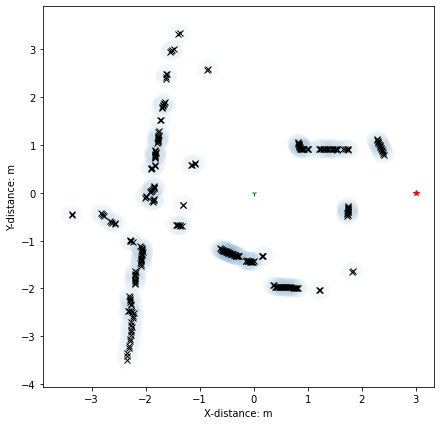

In [6]:
import math
import random
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import time
import numpy as np
import numpy as np
from tf_transformations import euler_from_quaternion
from geometry_msgs.msg import Twist


class Vector2d():

    def __init__(self, x, y):
        self.deltaX = x
        self.deltaY = y
        self.length = -1
        self.direction = [0, 0]
        self.vector2d_share()

    def vector2d_share(self):
        if type(self.deltaX) == type(list()) and type(self.deltaY) == type(list()):
            deltaX, deltaY = self.deltaX, self.deltaY
            self.deltaX = deltaY[0] - deltaX[0]
            self.deltaY = deltaY[1] - deltaX[1]
            self.length = math.sqrt(self.deltaX ** 2 + self.deltaY ** 2) * 1.0
            if self.length > 0:
                self.direction = [self.deltaX / self.length, self.deltaY / self.length]
            else:
                self.direction = None
        else:
            self.length = math.sqrt(self.deltaX ** 2 + self.deltaY ** 2) * 1.0
            if self.length > 0:
                self.direction = [self.deltaX / self.length, self.deltaY / self.length]
            else:
                self.direction = None

    def __add__(self, other):
        """
        :param other:
        :return:
        """
        vec = Vector2d(self.deltaX, self.deltaY)
        vec.deltaX += other.deltaX
        vec.deltaY += other.deltaY
        vec.vector2d_share()
        return vec

    def __sub__(self, other):
        vec = Vector2d(self.deltaX, self.deltaY)
        vec.deltaX -= other.deltaX
        vec.deltaY -= other.deltaY
        vec.vector2d_share()
        return vec

    def __mul__(self, other):
        vec = Vector2d(self.deltaX, self.deltaY)
        vec.deltaX *= other
        vec.deltaY *= other
        vec.vector2d_share()
        return vec

    def __truediv__(self, other):
        return self.__mul__(1.0 / other)

    def __repr__(self):
        return 'Vector deltaX:{}, deltaY:{}, length:{}, direction:{}'.format(self.deltaX, self.deltaY, self.length,
                                                                             self.direction)


class APF():


    def __init__(self, start: (), goal: (), obstacles: [], k_att: float, k_rep: float, rr: float,
                 step_size: float, max_iters: int, goal_threshold: float, is_plot=False):
        """
        :param start:
        :param goal: 
        :param obstacles: 
        :param k_att: 
        :param k_rep: 
        :param rr: 
        :param step_size: 
        :param max_iters:
        :param goal_threshold: 
        :param is_plot: 
        """
        self.start = Vector2d(start[0], start[1])
        self.current_pos = Vector2d(start[0], start[1])
        self.goal = Vector2d(goal[0], goal[1])
        self.obstacles = [Vector2d(OB[0], OB[1]) for OB in obstacles]
        self.k_att = k_att
        self.k_rep = k_rep
        self.rr = rr  
        self.step_size = step_size
        self.max_iters = max_iters
        self.iters = 0
        self.goal_threashold = goal_threshold
        self.path = list()
        self.is_path_plan_success = False
        self.is_plot = is_plot
        self.delta_t = 0.01

    def attractive(self):

        att = (self.goal - self.current_pos) * self.k_att 
        return att

 

class APF_Improved(APF):
    def __init__(self, start: (), goal: (), obstacles: [], k_att: float, k_rep: float, rr: float,
                 robot_radius: float, step_size: float, max_iters: int, goal_threshold: float, is_plot=False):
        self.start = Vector2d(start[0], start[1])
        self.current_pos = Vector2d(start[0], start[1])
        self.goal = Vector2d(goal[0], goal[1])
        self.obstacles = [Vector2d(OB[0], OB[1]) for OB in obstacles]
        self.k_att = k_att
        self.k_rep = k_rep
        self.rr = rr  # Radius of repulsion (circle radius)
        self.robot_radius = robot_radius  # Robot's radius
        self.step_size = step_size
        self.max_iters = max_iters
        self.iters = 0
        self.goal_threashold = goal_threshold
        self.path = list()
        self.is_path_plan_success = False
        self.is_plot = is_plot
        self.delta_t = 0.01

    def repulsion(self):
        rep = Vector2d(0, 0)
        for obstacle in self.obstacles:
            obs_to_rob = self.current_pos - obstacle
            rob_to_goal = self.goal - self.current_pos
            distance_to_obstacle = obs_to_rob.length - self.robot_radius
            if distance_to_obstacle <= self.rr:  # Check if the obstacle is within the repulsion radius
                rep_1 = Vector2d(obs_to_rob.direction[0], obs_to_rob.direction[1]) * self.k_rep * (
                            1.0 - distance_to_obstacle / self.rr) * (rob_to_goal.length ** 2)
                rep_2 = Vector2d(rob_to_goal.direction[0], rob_to_goal.direction[1]) * self.k_rep * (
                            (1.0 - distance_to_obstacle / self.rr) ** 2) * rob_to_goal.length
                rep += rep_1 + rep_2
        return rep


    def path_plan(self):
        """
        path plan
        :return:
        """
        while (self.iters < self.max_iters and (self.current_pos - self.goal).length > self.goal_threashold):
            f_vec = self.attractive() + self.repulsion()
            self.current_pos += Vector2d(f_vec.direction[0], f_vec.direction[1]) * self.step_size
            self.iters += 1
            self.path.append([self.current_pos.deltaX, self.current_pos.deltaY])

        if (self.current_pos - self.goal).length <= self.goal_threashold:
            self.is_path_plan_success = True

    def rt_path_plan(self):
        """
        path plan
        :return:
        """
        f_vec = self.attractive() + self.repulsion()
        self.current_pos += Vector2d(f_vec.direction[0], f_vec.direction[1]) * self.step_size
        return ([self.current_pos.deltaX, self.current_pos.deltaY])    

if __name__ == '__main__':

    robot.scan_future = rclpy.Future()
    robot.odom_future = rclpy.Future()
    robot.spin_until_future_completed(robot.scan_future)
    robot.spin_until_future_completed(robot.odom_future)
    pose = robot.last_odom_msg.pose.pose
    msg = robot.last_scan_msg
    

    k_att, k_rep = 5., 2
    rr =  0.2 #3
    step_size, max_iters, goal_threashold = .2, 1000 , .1
    step_size_ = .4
    robot_radius = 0.2
    start = (pose.position.x , pose.position.y)
    goal = (3, 0)
    is_plot = True

    print(start)
  
    ################
    # robot.reset_odometry()

    transformed_obs = plot_lidar_scan_points_working(robot.last_scan_msg,pose)


    ########################
    # path plan
    if is_plot:
        apf = APF_Improved(start, goal, transformed_obs, k_att, k_rep, rr,robot_radius , step_size, max_iters, goal_threashold, is_plot)
    else:
        apf = APF_Improved(start, goal, transformed_obs, k_att, k_rep, rr, robot_radius ,step_size, max_iters, goal_threashold, is_plot)
    apf.path_plan()
    x_co = []
    y_co = []
    if apf.is_path_plan_success:
        path = apf.path
        path_ = []
        i = int(step_size_ / step_size)
        while (i < len(path)):
            path_.append(path[i])
            i += int(step_size_ / step_size)
        # print("path len = " , len(path))
        if (len(path)!= 0) and (path_[-1] != path[-1]):  
            path_.append(path[-1])

        for point in path_:
            print(point)
            x_co.append(point[0])
            y_co.append(point[1])
            
        print('planed path points:{}'.format(path_))
        print('path plan success')
    else:
        print('path plan failed')

    
    fig = plt.figure(figsize=(7, 7))
    subplot = fig.add_subplot(111)
    subplot.set_xlabel('X-distance: m')
    subplot.set_ylabel('Y-distance: m')
    subplot.plot(start[0], start[1], '1' , color = 'green')
    subplot.plot(goal[0], goal[1], '*r')
    subplot.plot(x_co ,y_co , '.')
    for OB in transformed_obs:
        circle = Circle(xy=(OB[0], OB[1]), radius=rr, alpha=0.02)
        subplot.add_patch(circle)
        subplot.plot(OB[0], OB[1], 'xk')
    plt.show()



## HELPER FUNCTIONS

In [7]:
def generate_path(goal , robot_radius = 0.2 , step_size_ = 0.4):

    robot.odom_future = rclpy.Future()
    robot.spin_until_future_completed(robot.odom_future)
    pose = robot.last_odom_msg.pose.pose
    msg = robot.last_scan_msg

    k_att, k_rep = 5., 2.
    rr =  0.3 #3
    step_size, max_iters, goal_threashold = .2, 1500 , .1
    step_size_ = step_size_
    robot_radius = robot_radius
    start = (pose.position.x , pose.position.y)
    goal = (goal[0], goal[1])
  
    ################
    # robot.reset_odometry()


    transformed_obs = plot_lidar_scan_points_working(robot.last_scan_msg,pose)

    ########################

    # path plan
    apf = APF_Improved(start, goal, transformed_obs, k_att, k_rep, rr, robot_radius , step_size, max_iters, goal_threashold, is_plot)
    apf.path_plan()
    if apf.is_path_plan_success:
        path = apf.path
        path_ = []
        i = int(step_size_ / step_size)
        while (i < len(path)):
            path_.append(path[i])
            i += int(step_size_ / step_size)
        if (len(path)!= 0) and (path_[-1] != path[-1]):
            path_.append(path[-1])
        else:
            pass
        
        if len(path_) != 0:
            return path_
        else:
            pass
    
    

def GoTo(desiredx,desiredy):
    while True:
        # Localization
        robot.odom_future = rclpy.Future()
        pose = robot.spin_until_future_completed(robot.odom_future).pose.pose
        (currentx, currenty) = (pose.position.x, pose.position.y)
        yaw = np.arctan2(2 * (pose.orientation.w * pose.orientation.z + pose.orientation.x * pose.orientation.y),1 - 2 * (pose.orientation.y ** 2 + pose.orientation.z ** 2))

        # Navigation
        distance = np.sqrt((np.square(desiredx-currentx))+(np.square(desiredy-currenty)))
        angle_goal = np.arctan2((desiredy-currenty),(desiredx-currentx))
        angle_diff_rad = np.arctan2(np.sin(angle_goal-yaw), np.cos(angle_goal-yaw))
        vel_dir =  1*angle_diff_rad
        # print(angle_diff_rad)
        # print("x_pos" , currentx , "y_pos" , currenty ,"dist",distance,"angle",yaw,"angle_goal",angle_goal,end="\r")
        msg = Twist()
        
        if abs(angle_diff_rad) > 0.03:
            msg.linear.x = 0. #min(0.02, 1. * distance)
            msg.angular.z = float(max(-0.4,min(0.4, 0.25 * (vel_dir))))
            robot.cmd_vel_publisher.publish(msg)
        else:
            break

    while True:
        robot.odom_future = rclpy.Future()
        pose = robot.spin_until_future_completed(robot.odom_future).pose.pose
        (currentx, currenty) = (pose.position.x, pose.position.y)
        # print("x_pos" , currentx , "y_pos" , currenty ,"dist",distance,"angle",yaw,"angle_goal",angle_goal,end="\r")
      
        distance = np.sqrt((np.square(desiredx-currentx))+(np.square(desiredy-currenty)))
        msg.linear.x = max(0.15 , 1.0*0.2*distance)
        msg.angular.z = 0. #max(-0.1,min(0.1, 0.25 * (desired_yaw-yaw)))
        robot.cmd_vel_publisher.publish(msg)
        if(distance<0.07):
            return
        

def generate_real_time_path(goal , robot_radius = 0.2):

    robot.odom_future = rclpy.Future()
    robot.spin_until_future_completed(robot.odom_future)
    pose = robot.last_odom_msg.pose.pose
    msg = robot.last_scan_msg

    k_att, k_rep = 4., 1.5
    rr =  0.2 #3
    step_size, max_iters, goal_threashold = .2, 1500 , .1
    robot_radius = robot_radius
    start = (pose.position.x , pose.position.y)
    goal = (goal[0], goal[1])
  
    ################
    # robot.reset_odometry()


    transformed_obs = plot_lidar_scan_points_working(robot.last_scan_msg,pose)

    ########################
    # path plan
    apf = APF_Improved(start, goal, transformed_obs, k_att, k_rep, rr, robot_radius , step_size, max_iters, goal_threashold, is_plot)
    point = apf.rt_path_plan()
    return point

            
goal = (0,2.5)
# print(generate_path(goal , 0.2))




None


## AVOID OBSTACLES

In [38]:
# robot.reset_odometry()
goal  = (3, 0)
# goals = generate_path(goal , robot_radius)
# print(goals)
robot_radius = 0.2
#static
# path = generate_path(goal , robot_radius)
# for point in path:
#     print(point)
#     GoTo(point[1] , -point[0])

#dynamic
while True:
    robot.odom_future = rclpy.Future()
    pose = robot.spin_until_future_completed(robot.odom_future).pose.pose
    (currentx, currenty) = (pose.position.x, pose.position.y)
    try:
        path = generate_path(goal)
    except:
        break
    if path is not None:
        point  = path[0]
        print("At: " , currentx , ", " , currenty ,"\n Next point: " , point , end = '\r')
        GoTo(point[0] , point[1])
    else:
        print("going to goal")
        break
        

GoTo(goal[0] , goal[1])
robot.odom_future = rclpy.Future()
pose = robot.spin_until_future_completed(robot.odom_future).pose.pose
(currentx, currenty) = (pose.position.x, pose.position.y)
print("At: " , currentx , ", " , currenty)
print("\n Reached Goal")






In [11]:
goal  = (3, 0)
robot_radius = 0.25
while True:
    robot.odom_future = rclpy.Future()
    pose = robot.spin_until_future_completed(robot.odom_future).pose.pose
    (currentx, currenty) = (pose.position.x, pose.position.y)
    # Generate a new path based on the updated obstacle positions
    point = generate_real_time_path(goal, robot_radius)
    # Navigate the robot along the path\
    if (point is None) or (get_distance(currentx , currenty , goal[0] , goal[1])  <= 0.15):
        break

    print("At: " , currentx , ", " , currenty ,"\n Next point: " , point , end = '\r')
    GoTo(point[0], point[1])

GoTo(goal[0], goal[1])
print("\n Reached Goal")


At:  -4.323174289311282e-05 ,  5.060117837274447e-05 
At:  0.1380152702331543 ,  -0.0008772864239290357 267e-05]
At:  0.28704583644866943 ,  -0.0014932537451386452 0865509]
At:  0.4303326904773712 ,  -0.0023204952012747526 5840192]
At:  0.5817863941192627 ,  -0.0030481601133942604 1411217]
At:  0.7261751294136047 ,  -0.004421749617904425 63595112]
At:  0.8754744529724121 ,  -0.005579222925007343 8409749]
At:  1.0272289514541626 ,  -0.0068877264857292175 90579]
At:  1.1777974367141724 ,  -0.0080678416416049 731654965]
At:  1.3261581659317017 ,  -0.009765136986970901 922935]


KeyboardInterrupt: 

In [18]:
GoTo(1,0)

In [18]:
def goal_potential_gradient(x)
    return (1.,0.)

def scan_callback(scan):
    cmd = goal_potential_gradient(state)
    for point in scan:
        cmd += obs_potential_gradient(point)
    drive(cart2cmd(cmd))
    

In [ ]:
desiredx,desiredy = (3,0)
while True:
    # Localization
    robot.odom_future = rclpy.Future()
    pose = robot.spin_until_future_completed(robot.odom_future).pose.pose
    (currentx, currenty) = (pose.position.x, pose.position.y)
    yaw = np.arctan2(2 * (pose.orientation.w * pose.orientation.z + pose.orientation.x * pose.orientation.y),1 - 2 * (pose.orientation.y ** 2 + pose.orientation.z ** 2))

    # Navigation
    distance = np.sqrt((np.square(desiredx-currentx))+(np.square(desiredy-currenty)))
    angle_goal = np.arctan2((desiredy-currenty),(desiredx-currentx))
    angle_diff_rad = np.arctan2(np.sin(angle_goal-yaw), np.cos(angle_goal-yaw))
    vel_dir =  1*angle_diff_rad

    msg = Twist()
    
    if abs(angle_diff_rad) > 0.03:
        msg.linear.x = 0. #min(0.02, 1. * distance)
        msg.angular.z = max(-0.4,min(0.4, 0.25 * (vel_dir)))
        robot.cmd_vel_publisher.publish(msg)
    else:
        break

In [ ]:
def GoTo(desiredx,desiredy):
    while True:
        # Localization
        robot.odom_future = rclpy.Future()
        pose = robot.spin_until_future_completed(robot.odom_future).pose.pose
        (currentx, currenty) = (pose.position.x, pose.position.y)
        yaw = np.arctan2(2 * (pose.orientation.w * pose.orientation.z + pose.orientation.x * pose.orientation.y),1 - 2 * (pose.orientation.y ** 2 + pose.orientation.z ** 2))

        # Navigation
        distance = np.sqrt((np.square(desiredx-currentx))+(np.square(desiredy-currenty)))
        angle_goal = np.arctan2((desiredy-currenty),(desiredx-currentx))
        angle_diff_rad = np.arctan2(np.sin(angle_goal-yaw), np.cos(angle_goal-yaw))
        vel_dir =  1*angle_diff_rad
        # print(angle_diff_rad)
        # print("x_pos" , currentx , "y_pos" , currenty ,"dist",distance,"angle",yaw,"angle_goal",angle_goal,end="\r")
        msg = Twist()
        
        if abs(angle_diff_rad) > 0.03:
            msg.linear.x = 0. #min(0.02, 1. * distance)
            msg.angular.z = max(-0.4,min(0.4, 0.25 * (vel_dir)))
            robot.cmd_vel_publisher.publish(msg)
        else:
            break

    while True:
        robot.odom_future = rclpy.Future()
        pose = robot.spin_until_future_completed(robot.odom_future).pose.pose
        (currentx, currenty) = (pose.position.x, pose.position.y)
        # print("x_pos" , currentx , "y_pos" , currenty ,"dist",distance,"angle",yaw,"angle_goal",angle_goal,end="\r")
      
        distance = np.sqrt((np.square(desiredx-currentx))+(np.square(desiredy-currenty)))
        msg.linear.x = max(0.15 , 0.2*distance)
        msg.angular.z = 0. #max(-0.1,min(0.1, 0.25 * (desired_yaw-yaw)))
        robot.cmd_vel_publisher.publish(msg)
        if(distance<0.07):
            return

In [21]:
# import numpy
import numpy as np
# create list
x1 = [0, 10 , 20 , 30]
# convert the lists to 2D array using np.array
# f = np.array([x1, x2])

# compute the gradient of an N-dimensional array
# and store the result in result
result = np.gradient(x1)

print(result)

[10. 10. 10. 10.]


[[-4.0, -4.0, 9.9], [-4.0, -2.666666666666667, 9.01], [-4.0, -1.3333333333333335, 8.23], [-4.0, 0.0, 7.62], [-4.0, 1.333333333333333, 7.2], [-4.0, 2.666666666666666, 7.01], [-4.0, 4.0, 7.07], [-2.666666666666667, -4.0, 9.01], [-2.666666666666667, -2.666666666666667, 8.01], [-2.666666666666667, -1.3333333333333335, 7.13], [-2.666666666666667, 0.0, 6.41], [-2.666666666666667, 1.333333333333333, 5.91], [-2.666666666666667, 2.666666666666666, 5.68], [-2.666666666666667, 4.0, 5.75], [-1.3333333333333335, -4.0, 8.23], [-1.3333333333333335, -2.666666666666667, 7.13], [-1.3333333333333335, -1.3333333333333335, 6.13], [-1.3333333333333335, 0.0, 5.27], [-1.3333333333333335, 1.333333333333333, 4.64], [-1.3333333333333335, 2.666666666666666, 4.35], [-1.3333333333333335, 4.0, 4.45], [0.0, -4.0, 7.62], [0.0, -2.666666666666667, 6.41], [0.0, -1.3333333333333335, 5.27], [0.0, 0.0, 4.24], [0.0, 1.333333333333333, 3.43], [0.0, 2.666666666666666, 3.02], [0.0, 4.0, 3.16], [1.333333333333333, -4.0, 7.2], [

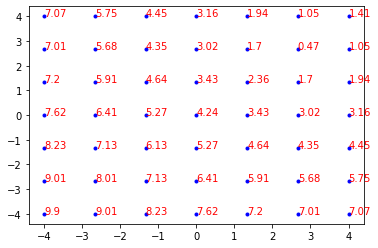

In [61]:
import numpy as np
import matplotlib.pyplot as plt

def potential_func(x, y , goal_x , goal_y):
    return np.sqrt((y - goal_y)**2 + (x - goal_x)**2)

def create_goal_gradient(goal):
    x = np.linspace(-4, 4, 7)
    y = np.linspace(-4, 4, 7)
    X, Y = np.meshgrid(x, y)
    goal_kp = 1
    points = []
    for ptx in x:
        for pty in y:
            points.append([ptx,pty])

    for pt in points:
        potential = goal_kp*potential_func(pt[0] , pt[1] , goal[0] , goal[1])
        pt.append(round(potential, 2))

    return X,Y,points


goal  = [3,3]
X,Y,points = create_goal_gradient(goal)
plt.plot(
        [x[0] for x in points],
        [x[1] for x in points],'b.')

for pt in points:
    plt.text(pt[0], pt[1], str(pt[2]), fontsize=10, color='red')
    
print(points)

[[-3.0, -3.0, 5.3852], [-3.0, -2.5, 5.2202], [-3.0, -2.0, 5.099], [-3.0, -1.5, 5.0249], [-3.0, -1.0, 5.0], [-3.0, -0.5, 5.0249], [-3.0, 0.0, 5.099], [-3.0, 0.5, 5.2202], [-3.0, 1.0, 5.3852], [-3.0, 1.5, 5.5902], [-3.0, 2.0, 5.831], [-3.0, 2.5, 6.1033], [-3.0, 3.0, 6.4031], [-2.5, -3.0, 4.9244], [-2.5, -2.5, 4.7434], [-2.5, -2.0, 4.6098], [-2.5, -1.5, 4.5277], [-2.5, -1.0, 4.5], [-2.5, -0.5, 4.5277], [-2.5, 0.0, 4.6098], [-2.5, 0.5, 4.7434], [-2.5, 1.0, 4.9244], [-2.5, 1.5, 5.1478], [-2.5, 2.0, 5.4083], [-2.5, 2.5, 5.7009], [-2.5, 3.0, 6.0208], [-2.0, -3.0, 4.4721], [-2.0, -2.5, 4.272], [-2.0, -2.0, 4.1231], [-2.0, -1.5, 4.0311], [-2.0, -1.0, 4.0], [-2.0, -0.5, 4.0311], [-2.0, 0.0, 4.1231], [-2.0, 0.5, 4.272], [-2.0, 1.0, 4.4721], [-2.0, 1.5, 4.717], [-2.0, 2.0, 5.0], [-2.0, 2.5, 5.3151], [-2.0, 3.0, 5.6569], [-1.5, -3.0, 4.0311], [-1.5, -2.5, 3.8079], [-1.5, -2.0, 3.6401], [-1.5, -1.5, 3.5355], [-1.5, -1.0, 3.5], [-1.5, -0.5, 3.5355], [-1.5, 0.0, 3.6401], [-1.5, 0.5, 3.8079], [-1.5, 1.

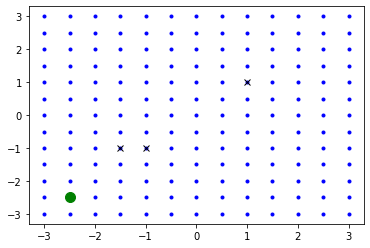

I am at: (-2.5, -2.5)
prev pt was  (-3, -3)
next pt should be [-2.0, -2.0, 4.1231]
I am going to  [-2.0, -2.0, 4.1231]


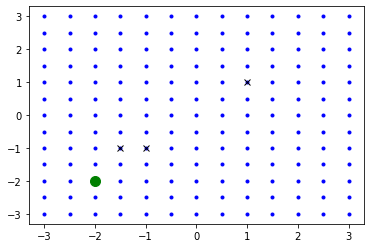

I am at: (-2.0, -2.0)
prev pt was  (-2.5, -2.5)
next pt should be [-1.5, -1.5, 3.5355]
I am going to  [-1.5, -1.5, 3.5355]


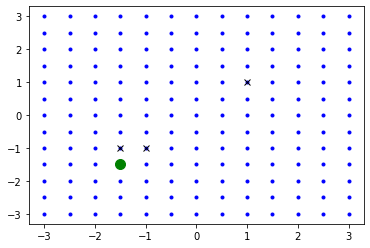

I am at: (-1.5, -1.5)
prev pt was  (-2.0, -2.0)
next pt should be [-1.0, -1.5, 3.0414]
I am going to  [-1.0, -1.5, 3.0414]


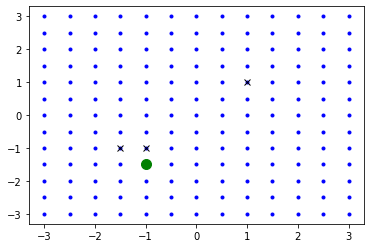

I am at: (-1.0, -1.5)
prev pt was  (-1.5, -1.5)
next pt should be [-0.5, -1.0, 2.5]
I am going to  [-0.5, -1.0, 2.5]


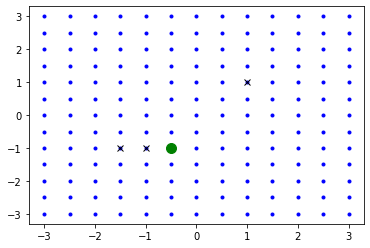

I am at: (-0.5, -1.0)
prev pt was  (-1.0, -1.5)
next pt should be [0.0, -1.0, 2.0]
I am going to  [0.0, -1.0, 2.0]


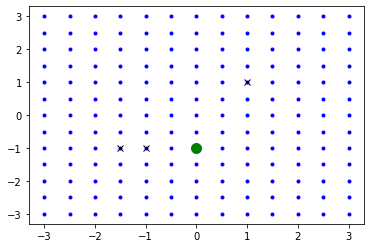

I am at: (0.0, -1.0)
prev pt was  (-0.5, -1.0)
next pt should be [0.5, -1.0, 1.5]
I am going to  [0.5, -1.0, 1.5]


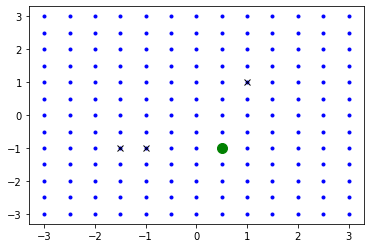

I am at: (0.5, -1.0)
prev pt was  (0.0, -1.0)
next pt should be [1.0, -1.0, 1.0]
I am going to  [1.0, -1.0, 1.0]


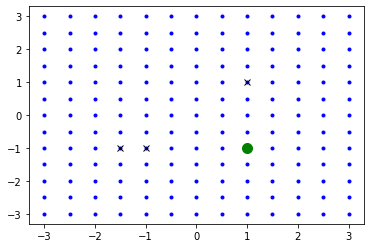

I am at: (1.0, -1.0)
prev pt was  (0.5, -1.0)
next pt should be [1.5, -1.0, 0.5]
I am going to  [1.5, -1.0, 0.5]


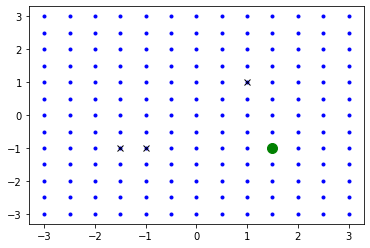

I am at: (1.5, -1.0)
prev pt was  (1.0, -1.0)
next pt should be [2.0, -1.0, 0.0]
I am going to  [2.0, -1.0, 0.0]


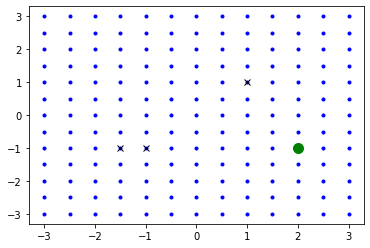

In [2]:
import numpy as np
import matplotlib.pyplot as plt

global grid_range
global num_grid_pts

grid_range , num_grid_pts = 3 , 13

def potential_func(x, y, goal_x, goal_y):
    return np.sqrt((y - goal_y)**2 + (x - goal_x)**2)

def create_goal_gradient(goal):
    x = np.linspace(-grid_range, grid_range, num_grid_pts)  # Increase the number of points in the grid to capture more detail
    y = np.linspace(-grid_range, grid_range, num_grid_pts)  # Increase the number of points in the grid to capture more detail
    #X, Y = np.meshgrid(x, y)
    goal_kp = 1
    points = []
    for ptx in x:
        for pty in y:
            points.append([round(ptx , 1), round(pty,1)])

    for pt in points:
        potential = goal_kp * potential_func(pt[0], pt[1], goal[0], goal[1])
        pt.append(round(potential, 4))

    return points

def get_adjacent_points(point):
    x, y = point
    gap = round((grid_range*2)/(num_grid_pts-1) ,2)
    adjacent_points = [
        (round(x-gap , 2), y),   # Left
        (round(x+gap , 2), y),   # Right
        (x, round(y-gap , 2)),   # Down
        (x, round(y+gap , 2)),   # Up
        (round(x-gap , 2), round(y-gap , 2)), # Diagonal top-left
        (round(x+gap , 2), round(y-gap , 2)), # Diagonal top-right
        (round(x-gap , 2), round(y+gap , 2)), # Diagonal bottom-left
        (round(x+gap , 2), round(y+gap , 2)) # Diagonal bottom-right
    ]
    
    # print("unsorted adj points")
    # print(adjacent_points)
    return adjacent_points

def find_adjacent_point_with_lowest_value(points ,goal, reference_point , previous_pt ):
    # points = create_goal_gradient(goal)
    unsorted_adj = get_adjacent_points(reference_point)
    # Find and filter adjacent points to the reference point
    adjacent_points = [pt for pt in points if (pt[0], pt[1]) in unsorted_adj]
    
    
    # Sort adjacent points based on their potential value
    adjacent_points.sort(key=lambda pt: pt[2])
    # print("sorted adj points")
    # print(adjacent_points)
    
    # Return the adjacent point with the lowest value
    print("prev pt was ", previous_pt)
    print("next pt should be" , adjacent_points[0])
    if ((adjacent_points[0][0] == previous_pt[0]) and (adjacent_points[0][1] == previous_pt[1]) ):
        return adjacent_points[1]

    return adjacent_points[0]

def get_distance(pt1 , pt2):
    return np.sqrt((pt1[0]-pt2[0])**2+((pt1[1]-pt2[1])**2))
# np.sqrt(pt[0]**2 + pt[1]**2) <= 3:  # Points within a distance of 3 units from (0, 0)

goal = [2, -1]
reference_point = (0, 0)
lowest_value_point = (-3,-3 , 1000)
points = create_goal_gradient(goal)
print(points)
# for i in range(3):
obs = ([-1,-1] ,[1,1] , [-1.5 ,-1])
obs = plot_lidar_scan_points(robot.last_scan_msg,pose)
for ob in obs:
    for pt in points:
        dist = get_distance(pt , ob)
        if (dist <=  0.3):
            # print(pt)
            pt[2]+= (1- np.round(dist , 3))


previous_pt = (100,100 , 0)
reference_points = []
while(lowest_value_point[2] > 0.2):
# for i in range(15):

    
    reference_point = (lowest_value_point[0],lowest_value_point[1])
    print("I am at:" , reference_point)
    # print("ref point is " , reference_point)
    lowest_value_point = find_adjacent_point_with_lowest_value(points , goal, reference_point , previous_pt)
    print("I am going to ", lowest_value_point)
    previous_pt = reference_point

    # Plot all points with potential values
    plt.plot(
        [x[0] for x in points],
        [x[1] for x in points], 'b.'
    )

    # for pt in points:
    #     plt.text(pt[0], pt[1], str(pt[2]), fontsize=10, color='red')

    # Plot adjacent point with the lowest value in green
    plt.plot(
        [lowest_value_point[0]],
        [lowest_value_point[1]], 'go', markersize=10
    )
    plt.plot(
        [x[0] for x in obs],
        [x[1] for x in obs], 'xk'
    )

    plt.show()
    # print("Adjacent point with the lowest value:", lowest_value_point)

In [68]:
print(np.linspace(-5,5,7))
print((10)/6)


[-5.         -3.33333333 -1.66666667  0.          1.66666667  3.33333333
  5.        ]
1.6666666666666667


In [ ]:
def grad_to_vel(dx,dy):
    while True:
        # Localization
        robot.odom_future = rclpy.Future()
        pose = robot.spin_until_future_completed(robot.odom_future).pose.pose
        (currentx, currenty) = (pose.position.x, pose.position.y)
        yaw = np.arctan2(2 * (pose.orientation.w * pose.orientation.z + pose.orientation.x * pose.orientation.y),1 - 2 * (pose.orientation.y ** 2 + pose.orientation.z ** 2))

        # Navigation
        distance = np.sqrt((np.square(dx))+(np.square(dy)))
        angle_goal = np.arctan2((dy),(dx))
        angle_diff_rad = np.arctan2(np.sin(angle_goal-yaw), np.cos(angle_goal-yaw))
        vel_dir =  1*angle_diff_rad
        # print(angle_diff_rad)
        # print("x_pos" , currentx , "y_pos" , currenty ,"dist",distance,"angle",yaw,"angle_goal",angle_goal,end="\r")
        msg = Twist()
        
        if abs(angle_diff_rad) > 0.03:
            msg.linear.x = 0. #min(0.02, 1. * distance)
            msg.angular.z = max(-0.4,min(0.4, 0.25 * (vel_dir)))
            robot.cmd_vel_publisher.publish(msg)
        else:
            break
        # print("x_pos" , currentx , "y_pos" , currenty ,"dist",distance,"angle",yaw,"angle_goal",angle_goal,end="\r")
      
        distance = np.sqrt((np.square(dx))+(np.square(dy)))
        msg.linear.x = max(0.15 , 0.2*distance)
        msg.angular.z = 0. #max(-0.1,min(0.1, 0.25 * (desired_yaw-yaw)))
        robot.cmd_vel_publisher.publish(msg)
        if(distance<0.07):
            return
        

